In [1]:
from gensim.models import KeyedVectors

In [2]:
EMBEDDING_FILE = './GoogleNews-vectors-negative300.bin.gz' 
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [40]:
import pandas as pd
import numpy as np 
import os

from tqdm import tqdm
tqdm.pandas()

/home/krzysztof/.conda/envs/ml-nlp/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [41]:
train = pd.read_csv('./data/Train.csv', sep=';')
test = pd.read_csv('./data/TestX.csv', sep=';')

train.opinion = train.opinion.apply(lambda x: x.replace("&#039;", "'"))
test.opinion = test.opinion.apply(lambda x: x.replace("&#039;", "'"))

In [42]:
train = train.drop_duplicates('opinion').reset_index(drop=True)

In [43]:
embed_size = 300 # how big is each word vector
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

In [44]:
train['opinion_length'] = train.opinion.apply(lambda x: len(x))
train['capital_counts'] = train.opinion.apply(lambda x: sum(1 for c in x if c.isupper()))
train['special_counts'] = train.opinion.apply(lambda x: sum(1 for c in x if c in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~'))
train['word_count'] = train.opinion.apply(lambda x: len(str(x).split()))
train['unique_word_count'] = train.opinion.apply(lambda x: len(set(str(x).split())))
train['mean_word_length'] = train.opinion.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
train['name_count'] = train.opinion.apply(lambda x: sum(1 for c in x.split() if c[0].isupper()))

test['opinion_length'] = test.opinion.apply(lambda x: len(x))
test['capital_counts'] = test.opinion.apply(lambda x: sum(1 for c in x if c.isupper()))
test['special_counts'] = test.opinion.apply(lambda x: sum(1 for c in x if c in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~'))
test['word_count'] = test.opinion.apply(lambda x: len(str(x).split()))
test['unique_word_count'] = test.opinion.apply(lambda x: len(set(str(x).split())))
test['mean_word_length'] = test.opinion.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['name_count'] = test.opinion.apply(lambda x: sum(1 for c in x.split() if c[0].isupper()))

meta_features = ['opinion_length', 'capital_counts', 'special_counts', 'word_count', 'unique_word_count', 'mean_word_length', 'name_count']

for feature in meta_features:
    max_value = train[feature].max()
    train[feature] = train[feature] / max_value
    test[feature] = test[feature] / max_value

condition_features = list(train.condition.value_counts().index)[:60]
for condition_feature in condition_features:
    train['condition_' + condition_feature] = (train.condition == condition_feature).astype(int)
    test['condition_' + condition_feature] = (test.condition == condition_feature).astype(int)

In [47]:
import operator 
import re


def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x


def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def clean_text(x):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x



def clean_numbers(x):

    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x


def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


mispell_dict = {'colour':'color',
                'centre':'center',
                'didnt':'did not',
                'doesnt':'does not',
                'isnt':'is not',
                'shouldnt':'should not',
                'favourite':'favorite',
                'travelling':'traveling',
                'counselling':'counseling',
                'theatre':'theater',
                'cancelled':'canceled',
                'labour':'labor',
                'organisation':'organization',
                'wwii':'world war 2',
                'citicise':'criticize',
                'instagram': 'social medium',
                'whatsapp': 'social medium',
                'snapchat': 'social medium'}
mispellings, mispellings_re = _get_mispell(mispell_dict)


def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

In [48]:
sentences = train["opinion"].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)

100%|██████████| 107590/107590 [00:01<00:00, 74799.58it/s]


In [49]:
oov = check_coverage(vocab, word2vec)

100%|██████████| 188722/188722 [00:00<00:00, 548854.52it/s]

Found embeddings for 20.39% of vocab
Found embeddings for  77.62% of all text


In [50]:
train['opinion'] = train['opinion'].str.replace('"', '')
train['opinion'] = train['opinion'].str.replace(',', '')
train['opinion'] = train['opinion'].str.replace('.', '')
train['opinion'] = train['opinion'].str.replace('!', '')
train['opinion'] = train['opinion'].str.replace(':', '')
train['opinion'] = train['opinion'].str.replace('&#039;ve', ' have')
train['opinion'] = train['opinion'].str.replace('&#039;s', ' is')
train['opinion'] = train['opinion'].str.replace('&#039;t', ' not')
train['opinion'] = train['opinion'].str.replace('&#039;m', ' am')
train['opinion'] = train['opinion'].str.replace('&#039;ll', '')
train['opinion'] = train['opinion'].str.replace('rsquot', '')
train['opinion'] = train['opinion'].str.replace('rsquom', '')
train['opinion'] = train['opinion'].str.replace('rsquos', '')

In [51]:
test['opinion'] = test['opinion'].str.replace('"', '')
test['opinion'] = test['opinion'].str.replace(',', '')
test['opinion'] = test['opinion'].str.replace('.', '')
test['opinion'] = test['opinion'].str.replace('!', '')
test['opinion'] = test['opinion'].str.replace(':', '')
test['opinion'] = test['opinion'].str.replace('&#039;ve', ' have')
test['opinion'] = test['opinion'].str.replace('&#039;s', ' is')
test['opinion'] = test['opinion'].str.replace('&#039;t', ' not')
test['opinion'] = test['opinion'].str.replace('&#039;m', ' am')
test['opinion'] = test['opinion'].str.replace('&#039;ll', '')
test['opinion'] = test['opinion'].str.replace('rsquot', '')
test['opinion'] = test['opinion'].str.replace('rsquom', '')
test['opinion'] = test['opinion'].str.replace('rsquos', '')

In [52]:
train["opinion"] = train["opinion"].progress_apply(lambda x: clean_text(x))
train["opinion"] = train["opinion"].progress_apply(lambda x: clean_numbers(x))
train["opinion"] = train["opinion"].progress_apply(lambda x: replace_typical_misspell(x))

100%|██████████| 107590/107590 [00:01<00:00, 81952.82it/s]


In [53]:
test["opinion"] = test["opinion"].progress_apply(lambda x: clean_text(x))
test["opinion"] = test["opinion"].progress_apply(lambda x: clean_numbers(x))
test["opinion"] = test["opinion"].progress_apply(lambda x: replace_typical_misspell(x))

100%|██████████| 50000/50000 [00:00<00:00, 81643.02it/s]


In [54]:
sentences = train["opinion"].progress_apply(lambda x: x.split())
to_remove = ['a','to','of','and']
sentences = [[word for word in sentence if not word in to_remove] for sentence in tqdm(sentences)]
vocab = build_vocab(sentences)

100%|██████████| 107590/107590 [00:01<00:00, 95896.34it/s]


In [55]:
oov = check_coverage(vocab,word2vec)

100%|██████████| 74690/74690 [00:00<00:00, 524081.88it/s]

Found embeddings for 57.90% of vocab
Found embeddings for  99.12% of all text


In [56]:
oov[:10]

[('Nexplanon', 1254),
 ('Sprintec', 824),
 ('nexplanon', 744),
 ('rsquot', 673),
 ('Belviq', 585),
 ('mirena', 445),
 ('rsquom', 442),
 ('skyla', 399),
 ('rsquos', 382),
 ('implanon', 366)]

In [57]:
top_oov = [i for i, j in oov[:40]]

In [58]:
for oov_word in top_oov:
    train['oov_' + oov_word] = train.opinion.apply(lambda x: oov_word in x)
    test['oov_' + oov_word] = test.opinion.apply(lambda x: oov_word in x)

In [59]:
features = meta_features + ['condition_' + i for i in condition_features] + ['oov_' + i for i in top_oov]

In [60]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train, test_size=0.08, random_state=42)

X_train_meta = np.array(train_df.loc[:, features]).astype(np.float32)
X_val_meta = np.array(val_df.loc[:, features]).astype(np.float32)
X_test_meta = np.array(test.loc[:, features]).astype(np.float32)

X_train = train_df.opinion.values
X_val = val_df.opinion.values
X_test = test.opinion.values

In [61]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = max_features)

In [62]:
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [63]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [64]:
y_train = train_df['rate1'].values
y_val = val_df['rate1'].values

In [65]:
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPool1D, Bidirectional, LSTM, Embedding, Input, Concatenate, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K

In [66]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((max_features, embed_size))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec.get_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            embedding_vector = None
    except:
        pass


In [67]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

print(le.classes_)

y_train = le.transform(y_train)
y_val = le.transform(y_val)

['high' 'low' 'medium']


In [68]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


In [69]:
from lstm_models_cls import model_1

In [72]:
#for i in range(10):
i = 0   
X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(
    np.concatenate((X_train, X_train_meta), axis=1), 
    y_train, 
    test_size=0.05)

X_train_tmp, X_train_tmp_meta = X_train_tmp[:,:100], X_train_tmp[:,100:]
X_val_tmp, X_val_tmp_meta = X_val_tmp[:,:100], X_val_tmp[:,100:]


model = model_1.get_model(embedding_matrix, maxlen, max_features, embed_size, len(features))
adam = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

print("##################################################")
print(f'Model 1, iteration {i}')

callback_earlystop = tf.keras.callbacks.EarlyStopping(patience=5,
                                           monitor='val_loss',
                                           mode='auto',
                                           restore_best_weights=True)


model.fit([X_train_tmp, X_train_tmp_meta], y_train_tmp, epochs = 20, batch_size=256,
          callbacks=[callback_earlystop], validation_data=([X_val_tmp, X_val_tmp_meta], y_val_tmp))

y_hat_val = model.predict([X_val, X_val_meta]).astype('float32')
y_hat_val.tofile(f'./results/Model_1_{i}_val_cls')

y_hat_test = model.predict([X_test, X_test_meta]).astype('float32')
y_hat_test.tofile(f'./results/Model_1_{i}_test_cls')

##################################################
Model 1, iteration 0
Train on 94032 samples, validate on 4950 samples
Epoch 1/20
94032/94032 [==============================] - 29s 303us/sample - loss: 0.7341 - accuracy: 0.6904 - val_loss: 0.6430 - val_accuracy: 0.7295
Epoch 2/20
94032/94032 [==============================] - 25s 268us/sample - loss: 0.5881 - accuracy: 0.7561 - val_loss: 0.6109 - val_accuracy: 0.7386
Epoch 3/20
94032/94032 [==============================] - 26s 272us/sample - loss: 0.5382 - accuracy: 0.7773 - val_loss: 0.5928 - val_accuracy: 0.7507
Epoch 4/20
94032/94032 [==============================] - 26s 273us/sample - loss: 0.4989 - accuracy: 0.7954 - val_loss: 0.5892 - val_accuracy: 0.7477
Epoch 5/20
94032/94032 [==============================] - 26s 274us/sample - loss: 0.4631 - accuracy: 0.8111 - val_loss: 0.6175 - val_accuracy: 0.7349
Epoch 6/20
94032/94032 [==============================] - 26s 274us/sample - loss: 0.4217 - accuracy: 0.8291 - val_loss: 0.6

In [75]:
np.argmax(y_hat_test, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [76]:
from matplotlib import pyplot as plt

(array([32207.,     0.,     0.,     0.,     0., 10893.,     0.,     0.,
            0.,  6900.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

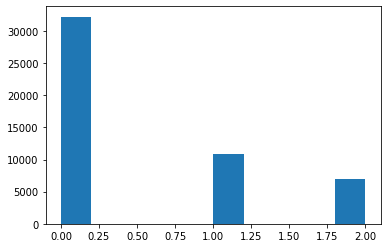

In [77]:
plt.hist(np.argmax(y_hat_test, axis=1))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_hat_val, y_val)

In [ ]:
np.argmax(y_hat_val, axis=1)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.hist(np.argmax(y_hat_val, axis=1))

In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_hat_val, axis=1))

In [ ]:
y_h = np.zeros_like(y_hat_val)

In [ ]:
for i in range(10):
    y_hat_tmp = np.fromfile(f'./results/Model_1_{i}_val_cls', dtype='float32').reshape(-1, 3)
    
    y_hat_tmp_cat = to_categorical(np.argmax(y_hat_tmp, axis=1))
    
    y_h = y_h + y_hat_tmp_cat

y_h = y_h + np.random.normal(size=y_h.shape)/1e4    

accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_h, axis=1))

In [ ]:
y_hat_tmp = np.fromfile(f'./results/Model_1_9_val_cls', dtype='float32')

In [ ]:
y_hat_tmp.reshape(-1, 3)

In [ ]:
y_h

In [ ]:
y_hat_tmp = np.fromfile(f'./results/Model_1_0_val_cls', dtype='float32').reshape(-1, 3)
np.random.normal(size=y_hat_tmp.shape)/1e4

In [ ]:
y_hat_tmp.shape

In [ ]:
X_test.shape